In [2]:
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as nnf
from torch.optim.lr_scheduler import ReduceLROnPlateau

import numpy as np

from tqdm import tqdm

import matplotlib.pyplot as plt

from util import load_Cifar10

cuda = True
DEVICE = torch.device("cuda" if cuda and torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [3]:
class Encoder(nn.Module):

    def __init__(self, latent_dim):
        super(Encoder, self).__init__()

        self.latent_dim = latent_dim

        self.conv1 = nn.Conv2d(3, 32, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, stride=1, padding=1)

        self.fc1 = nn.Linear(256*4*4, 512)
        self.FC_mean  = nn.Linear(512, latent_dim)
        self.FC_var   = nn.Linear (512, latent_dim)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))

        x = x.view(-1, 256*4*4)

        x = self.relu(self.fc1(x))
        mean = self.FC_mean(x)
        log_var = self.FC_var(x)

        return mean, log_var


In [4]:
class Decoder(nn.Module):
    
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()

        self.latent_dim = latent_dim

        self.fc1 = nn.Linear(latent_dim, 512)
        self.fc2 = nn.Linear(512, 256*4*4)

        self.deconv1 = nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(64, 32, 3, stride=1, padding=0)
        self.deconv4 = nn.ConvTranspose2d(32, 3, 3, stride=2, padding=0, output_padding=1)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))

        x = x.view(-1, 256, 4, 4)

        x = self.relu(self.deconv1(x))
        x = self.relu(self.deconv2(x))
        x = self.relu(self.deconv3(x))
        x = self.deconv4(x)

        return x

In [5]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        self.loss = []

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)
        z = mean + var*epsilon
        return z

    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var))
        x_hat = self.Decoder(z)

        return x_hat, mean, log_var

In [6]:
x_dim = 32
channels = 3

scale_factor = 2
x_inp_dim  = int(x_dim / scale_factor)


hidden_dim = 500
latent_dim = 200

lr = 1e-3
epochs = 1000
batch_size = 512

train_dataset, test_dataset, train_loader, test_loader, classes = load_Cifar10(batch_size, [1])
num_train_data = len(train_dataset)

In [7]:
encoder = Encoder(latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

In [8]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = -0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

optimizer = Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=10, threshold=0.0001)

In [9]:
print("Start training VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x_inp = nnf.interpolate(x, size=(x_inp_dim, x_inp_dim), mode='bicubic', align_corners=False)
        # x_inp = x_inp.view(-1, x_inp_dim**2*channels)
        x_inp = x_inp.to(DEVICE)

        # x = x.view(-1, x_dim**2*channels)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x_inp)
        x_hat = (x_hat - torch.min(x_hat)) / (torch.max(x_hat) - torch.min(x_hat))
        loss = loss_function(x, x_hat, mean, log_var)

        overall_loss += loss.item() / num_train_data

        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print("\tEpoch", epoch, "complete!", "\tAverage Loss: ", overall_loss)

    model.loss.append(overall_loss)
    scheduler.step(overall_loss)

print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss)
print("Finish!!")

Start training VAE...
	Epoch 0 complete! 	Average Loss:  2337.3544375
	Epoch 10 complete! 	Average Loss:  2113.6522250000003
	Epoch 20 complete! 	Average Loss:  2103.29705
	Epoch 30 complete! 	Average Loss:  2103.5762375000004
	Epoch 40 complete! 	Average Loss:  2104.9690625
	Epoch 50 complete! 	Average Loss:  2082.9201375
	Epoch 60 complete! 	Average Loss:  2060.332675
	Epoch 70 complete! 	Average Loss:  2051.4517125
	Epoch 80 complete! 	Average Loss:  2054.7285375
	Epoch 90 complete! 	Average Loss:  2043.28815
	Epoch 100 complete! 	Average Loss:  2040.522175
	Epoch 110 complete! 	Average Loss:  2048.3683
	Epoch 120 complete! 	Average Loss:  2041.3028875
	Epoch 130 complete! 	Average Loss:  2034.0689750000001
	Epoch 140 complete! 	Average Loss:  2031.1046875
	Epoch 150 complete! 	Average Loss:  2029.4262875
	Epoch 160 complete! 	Average Loss:  2028.1667625000002
	Epoch 170 complete! 	Average Loss:  2028.116225
	Epoch 180 complete! 	Average Loss:  2025.5669874999999
	Epoch 190 complete

KeyboardInterrupt: 

[]

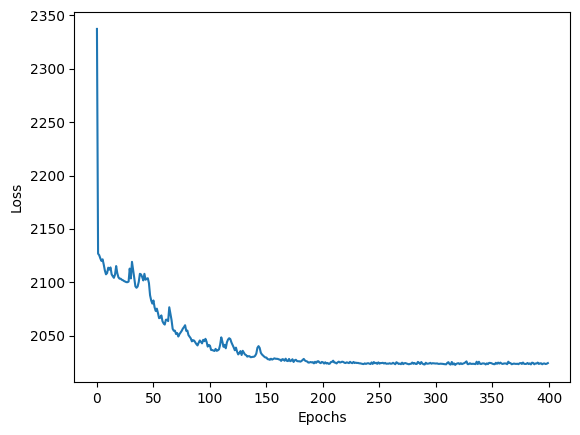

In [10]:
plt.plot(model.loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot()

In [11]:
model.eval()

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        x_inp = nnf.interpolate(x, size=(x_inp_dim, x_inp_dim), mode='bicubic', align_corners=False)
        #x_inp = x_inp.view(batch_size, x_inp_dim**2*channels)
        x_inp = x_inp.to(DEVICE)

        #x = x.view(batch_size, x_dim**2*channels)
        x = x.to(DEVICE)

        x_hat, _, _ = model(x_inp)
        x_hat = (x_hat - torch.min(x_hat)) / (torch.max(x_hat) - torch.min(x_hat))

        break

  0%|          | 0/2 [00:00<?, ?it/s]


In [12]:
def show_image(x, x_inp, x_hat, n):
    x = x.view(batch_size, channels, x_dim, x_dim)
    x_inp = x_inp.view(batch_size, channels, x_inp_dim, x_inp_dim)
    x_hat = x_hat.view(batch_size, channels, x_dim, x_dim)


    fig, axs = plt.subplots(3, n, figsize=(20, 6))
    for i in range(n):
        axs[0, i].imshow(x[i].permute(1, 2, 0).cpu().numpy(),)
        axs[0, i].axis('off')

        axs[1, i].imshow(x_inp[i].permute(1, 2, 0).cpu().numpy())
        axs[1, i].axis('off')

        axs[2, i].imshow(x_hat[i].permute(1, 2, 0).cpu().numpy())
        axs[2, i].axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.011979165..1.0094516].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0991843..1.02837].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.00048636645..0.894581].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.017172182..0.996649].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.05640319..1.0111022].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04342448..1.0417739].


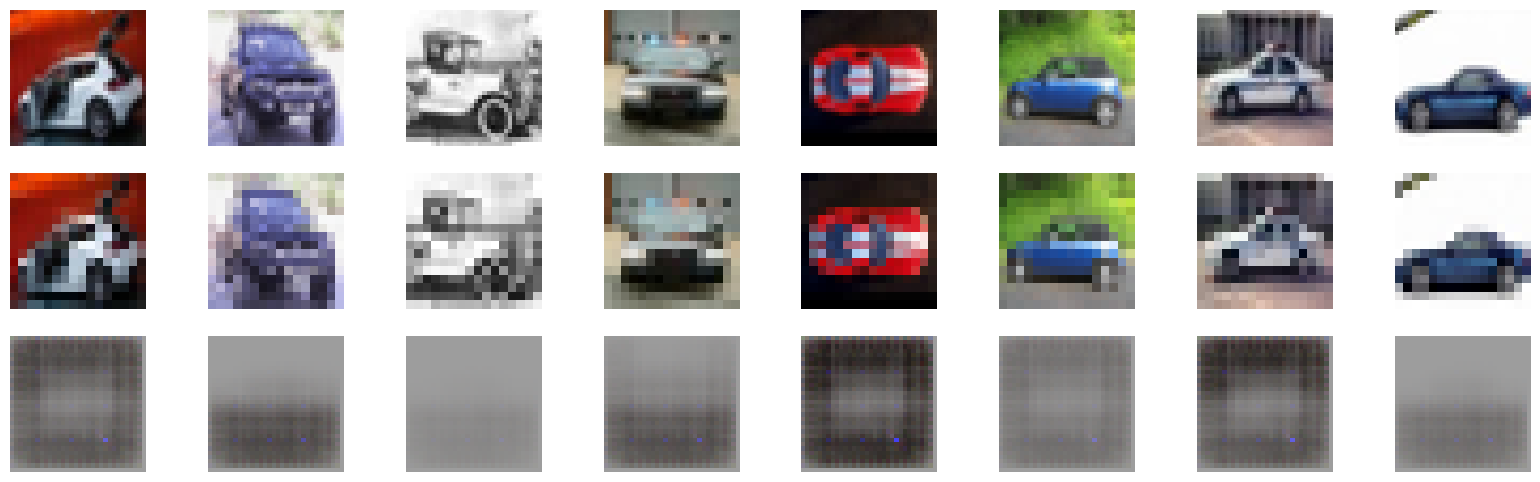

In [13]:
show_image(x, x_inp, x_hat, 8)